<a href="https://colab.research.google.com/github/gmshashank/Quality_Inspection/blob/main/Manufacturing_Quality_Inspection_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms

from random import randint
from torchvision import datasets,models

In [2]:
import os
os.getcwd()
os.makedirs("manufacturing_quality_inspection",exist_ok=True)
os.chdir("/content/manufacturing_quality_inspection")
os.getcwd()

'/content/manufacturing_quality_inspection'

## Data Preprocessing

In [3]:
!wget https://manufacturing-models.s3.eu-west-2.amazonaws.com/Castings.zip
!unzip Castings.zip

Streaming output truncated to the last 5000 lines.
  inflating: casting_data/casting_data/train/def_front/cast_def_0_5259.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_526.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_5260.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_5262.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_5265.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_527.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_5270.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_5272.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_5274.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_528.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_5282.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_5283.jpeg  
  inflating: cas

In [21]:
import enum
class LR_UPDATE_TY(enum.Enum):
      NONE=0,
      EPOCHWISE=1,
      BATCHWISE=2

config_params=dict(
    seed=1,
    batch_size=256,
    num_workers=4,
    epochs=25,
    lr_update_ty=LR_UPDATE_TY.EPOCHWISE,
    resume_training=False,
    load_model_path=""
)

torch.manual_seed(config_params["seed"])
if torch.cuda.is_available():
  torch.cuda.manual_seed(config_params["seed"])

In [5]:
transformations=transforms.Compose(
    [
     transforms.Resize(255),
     transforms.ToTensor(),     
    ]
)

def load_train_data(train_dir="./train",test_dir="./test"):
  train_data=datasets.ImageFolder(train_dir,transform=transformations)
  test_data=datasets.ImageFolder(test_dir,transform=transformations)

  train_loader=torch.utils.data.DataLoader(train_data,batch_size=config_params["batch_size"],shuffle=True,num_workers=config_params["num_workers"])
  test_loader=torch.utils.data.DataLoader(test_data,batch_size=config_params["batch_size"],shuffle=True,num_workers=config_params["num_workers"])

  return train_loader,test_loader

DATA_PATH=f"{os.getcwd()}/casting_data/casting_data"
train_loader,test_loader=load_train_data(train_dir=DATA_PATH + "/train",test_dir=DATA_PATH + "/test")
print(test_loader.dataset.classes)

['def_front', 'ok_front']


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [6]:
def imshow(img):
  npimg=img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()


images,labels=iter(train_loader).next()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


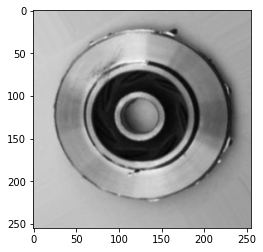

Image Size: torch.Size([3, 255, 255])


In [7]:
image=images[randint(0,16)]
imshow(image)
print(f"Image Size: {image.shape}")

## Load pre Trained Model

In [8]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
def freeze_all_layers(model):
  for name,layer in model.named_modules():
    for parameter in layer.parameters():
      parameter.requires_grad=False

def unfreeze_layers_by_name(model,unfreeze_layer_names_list):
  for name, layer in model.named_modules():
    unfreeze=any(n in name for n in unfreeze_layer_names_list)
    for parameter in layer.parameters():
      if (unfreeze):
          parameter.requires_grad=True
      else:
        parameter.requires_grad=False

def unfreeze_layers_by_ids(model,unfreeze_layer_by_ids_list):
  for idx in range(19):
    for param in model.features[idx].parameters():
      if idx in unfreeze_layer_by_ids_list:
          param.requires_grad=True
      else:
        param.requires_grad=False

def show_layers(model):
  for name,layer in model.named_modules():
    for parameter in layer.parameters():
      print(f"Layer name: {name}, requires_grad: {parameter.requires_grad}")

In [42]:
model=models.mobilenet_v2(pretrained=True)

# unfreeze last 3 layers of model for training
unfreeze_layer_names_list=["features.17","features.18","classifier"]
unfreeze_layers_by_name(model,unfreeze_layer_names_list)

In [43]:
show_layers(model)

Layer name: , requires_grad: False
Layer name: , requires_grad: False
Layer name: , requires_grad: False
Layer name: , requires_grad: False
Layer name: , requires_grad: False
Layer name: , requires_grad: False
Layer name: , requires_grad: False
Layer name: , requires_grad: False
Layer name: , requires_grad: False
Layer name: , requires_grad: False
Layer name: , requires_grad: False
Layer name: , requires_grad: False
Layer name: , requires_grad: False
Layer name: , requires_grad: False
Layer name: , requires_grad: False
Layer name: , requires_grad: False
Layer name: , requires_grad: False
Layer name: , requires_grad: False
Layer name: , requires_grad: False
Layer name: , requires_grad: False
Layer name: , requires_grad: False
Layer name: , requires_grad: False
Layer name: , requires_grad: False
Layer name: , requires_grad: False
Layer name: , requires_grad: False
Layer name: , requires_grad: False
Layer name: , requires_grad: False
Layer name: , requires_grad: False
Layer name: , requir

In [44]:
# adding custom Fully connected layer for classification
model.classifier=nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(1280,512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512,1024),
    nn.Linear(1024,2),
    nn.LogSoftmax(dim=1))

In [45]:
from torchsummary import summary
model=model.to(device)
summary(model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

## Build and Train model

In [46]:
EPOCHS = config_params['epochs']
max_lr = 0.1   # maximum LR 
min_lr = 1e-3   # minimum LR 
L2_val = 1e-4 # L2 Regularization
start_epoch = 1
step_size = 8 # num of epoch, if LR is update epoch wise
if config_params["lr_update_ty"] == LR_UPDATE_TY.BATCHWISE:
  step_size = 2000


In [47]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=min_lr, momentum=0.9, nesterov=True, weight_decay=L2_val)  

In [48]:
EPOCHS=20
steps=0
running_loss=0
print_every=10
train_losses=[]
test_losses=[]

for epoch in range(EPOCHS):
  for inputs,labels in train_loader:
    steps +=1
    inputs,labels=inputs.to(device),labels.to(device)
    optimizer.zero_grad()
    prediction=model.forward(inputs)
    loss=criterion(prediction,labels)
    loss.backward()
    optimizer.step()
    running_loss +=loss.item()

    if steps % print_every ==0:
      test_loss=0
      accuracy=0
      model.eval()
      with torch.no_grad():
        for inputs,labels in test_loader:
          inputs,labels=inputs.to(device),labels.to(device)
          prediction=model.forward(inputs)
          batch_loss=criterion(prediction,labels)
          test_loss +=batch_loss.item()
          
          ps=torch.exp(prediction)
          top_p,top_class=ps.topk(1,dim=1)
          equals=top_class==labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
      
      train_losses.append(running_loss/len(train_loader))
      test_losses.append(test_loss/len(test_loader))

      print(
          f"Epoch {epoch+1}/{EPOCHS}.."
          f"Train loss: {running_loss/print_every:.3f}.."
          f"Test loss: {test_loss/len(test_loader):.3f}.."
          f"Test accuracy: {accuracy/len(test_loader):.3f}")
      running_loss=0
      model.train()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1/20..Train loss: 0.688..Test loss: 0.682..Test accuracy: 0.645
Epoch 1/20..Train loss: 0.659..Test loss: 0.635..Test accuracy: 0.662
Epoch 2/20..Train loss: 0.632..Test loss: 0.610..Test accuracy: 0.878
Epoch 2/20..Train loss: 0.593..Test loss: 0.588..Test accuracy: 0.837
Epoch 2/20..Train loss: 0.552..Test loss: 0.560..Test accuracy: 0.781
Epoch 3/20..Train loss: 0.506..Test loss: 0.479..Test accuracy: 0.863
Epoch 3/20..Train loss: 0.439..Test loss: 0.393..Test accuracy: 0.916
Epoch 4/20..Train loss: 0.380..Test loss: 0.320..Test accuracy: 0.939
Epoch 4/20..Train loss: 0.314..Test loss: 0.262..Test accuracy: 0.946
Epoch 4/20..Train loss: 0.253..Test loss: 0.217..Test accuracy: 0.947
Epoch 5/20..Train loss: 0.217..Test loss: 0.182..Test accuracy: 0.960
Epoch 5/20..Train loss: 0.181..Test loss: 0.156..Test accuracy: 0.963
Epoch 5/20..Train loss: 0.154..Test loss: 0.137..Test accuracy: 0.963
Epoch 6/20..Train loss: 0.133..Test loss: 0.119..Test accuracy: 0.972
Epoch 6/20..Train lo

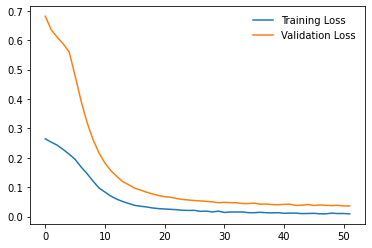

In [49]:
plt.plot(train_losses,label="Training Loss")
plt.plot(test_losses,label="Validation Loss")
plt.legend(frameon=False)
plt.show()

In [50]:
# Save the trained model
torch.save(model,"mobilenet_v2.pt")

In [52]:
model.eval()
traced_model = torch.jit.trace(model, torch.randn(1, 3, 224, 224).to(device))
traced_model.save("mobilenet_v2_traced.pt")


## LR Finder

In [14]:
os.chdir(os.getcwd())

In [15]:
import torch.optim as optim
from utils.lr_finder import LRFinder 
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=1e-7,momentum=0.9,weight_decay=1e-4)
lr_finder=LRFinder(model,optimizer,criterion,device=device)
lr_finder.range_test(train_loader,end_lr=100,num_iter=200,step_mode="exp")

  pip install torch-lr-finder -v --global-option="amp"
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


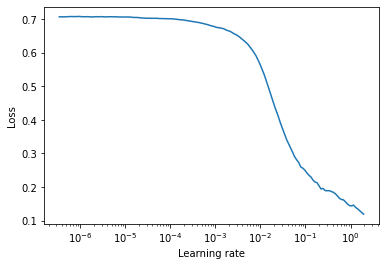

In [16]:
lr_finder.plot()

In [17]:
# restore model and optimizer to initial state
lr_finder.reset()
lr_finder.range_test(train_loader,val_loader=test_loader,end_lr=100,num_iter=200,step_mode="exp")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


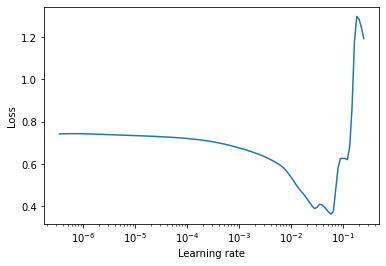

In [18]:
lr_finder.plot()

In [22]:
import torch.optim as optim
from torch.optim.lr_scheduler import CyclicLR, ReduceLROnPlateau
import torch.nn.functional as F

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=min_lr, momemtum=0.9, nesterov=True, weight_decay=L2_val) 
optimizer = optim.SGD(model.parameters(), lr=min_lr, momentum=0.9, nesterov=True, weight_decay=L2_val)  

# CyclicLR- use one cycle policy: MAX-LR at epoch=5, Triangular policy
lr_scheduler = CyclicLR(optimizer, base_lr=min_lr, max_lr=max_lr, step_size_up=step_size, step_size_down=step_size, mode='triangular2', last_epoch=-1)

# reduce LR when modle get stuck in plateu region
reduceLr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, threshold=0.001)

In [ ]:
# from utils.model_utils import ModelUtils
# mutils = ModelUtils(model, 
#                     device, 
#                     train_loader=train_loader, 
#                     test_loader=test_loader, 
#                     start_epoch = start_epoch,
#                     epochs=EPOCHS,
#                     criterion=criterion, 
#                     optimizer=optimizer,
#                     lr_scheduler=lr_scheduler,
#                     lr_update_ty=config_params['lr_update_ty'],
#                     reduceLr_scheduler=reduceLr_scheduler,
#                     saved_model_dir=SAVED_MODELS_DIR,
#                     tqdm_status = True)

In [ ]:
# m_history = mutils.build()